# Ponderada do Spotify - Marco Ruas Sales Peixoto - marco.peixoto@sou.inteli.edu.br

## Importando bibliotecas

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns


## Importando dataset

In [5]:
# Carregar o conjunto de treinamento
df_treino = pd.read_csv('train.csv')
df_teste = pd.read_csv('test.csv')

# Exemplo de visualização inicial dos dados
df_treino.head()
df_treino.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79800 entries, 0 to 79799
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_unique_id    79800 non-null  int64  
 1   track_id           79800 non-null  object 
 2   artists            79800 non-null  object 
 3   album_name         79800 non-null  object 
 4   track_name         79800 non-null  object 
 5   duration_ms        79800 non-null  int64  
 6   explicit           79800 non-null  bool   
 7   danceability       79800 non-null  float64
 8   energy             79800 non-null  float64
 9   key                79800 non-null  int64  
 10  loudness           79800 non-null  float64
 11  mode               79800 non-null  int64  
 12  speechiness        79800 non-null  float64
 13  acousticness       79800 non-null  float64
 14  instrumentalness   79800 non-null  float64
 15  liveness           79800 non-null  float64
 16  valence            798

## Codificando variáveis

In [6]:
# Codificando variáveis categóricas usando LabelEncoder
categorical_cols = ['track_genre']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_treino[col] = le.fit_transform(df_treino[col].astype(str))
    label_encoders[col] = le

# Codificando variáveis categóricas no conjunto de teste
for col in categorical_cols:
    if col in df_teste.columns:
        le = label_encoders[col]  # Usar o LabelEncoder treinado no conjunto de treino
        df_teste[col] = le.transform(df_teste[col].astype(str))


## Excluindo colunas

In [7]:
df_treino = df_treino.drop(columns=['track_unique_id', 'track_id', 'artists', 'album_name', 'track_name'])
df_teste = df_teste.drop(columns=['track_id', 'artists', 'album_name', 'track_name'])


## Tratamento de dados

In [8]:
# Verificando valores nulos
print(df_treino.isnull().sum())

# Imputação de valores nulos numéricos com média
df_treino.fillna(df_treino.median(), inplace=True)

duration_ms          0
explicit             0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
track_genre          0
popularity_target    0
dtype: int64


## Exploração Exploratória de Dados

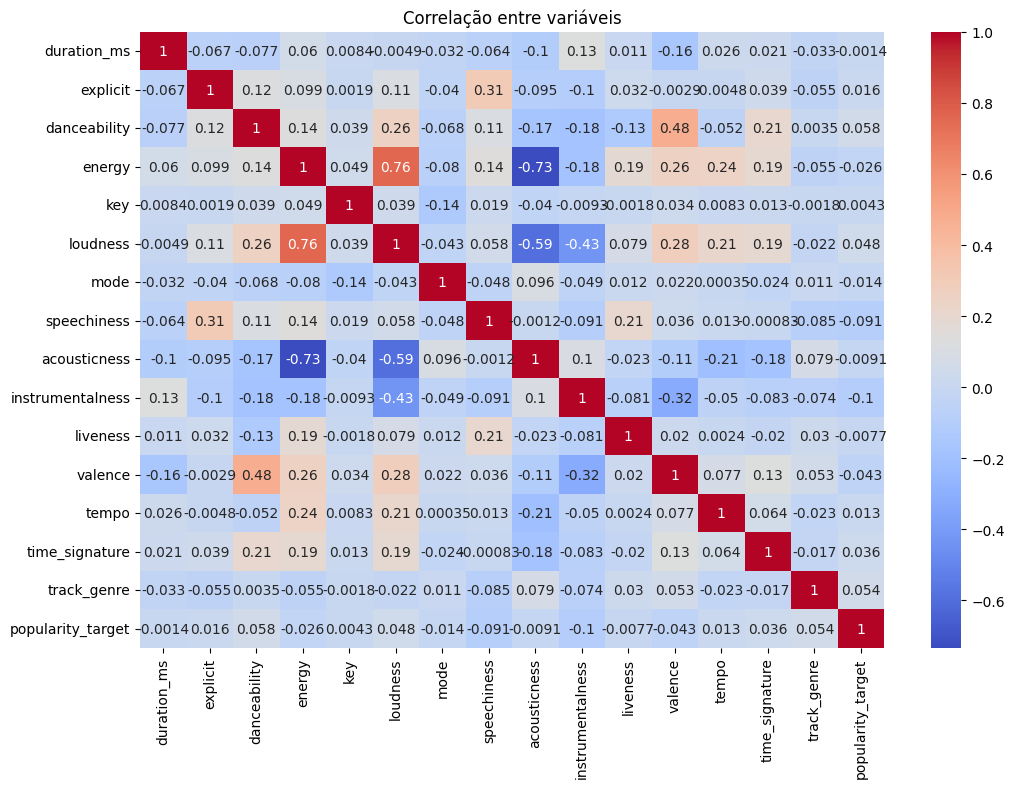

In [9]:
# Correlação entre as variáveis
plt.figure(figsize=(12, 8))
sns.heatmap(df_treino.corr(), annot=True, cmap='coolwarm')
plt.title('Correlação entre variáveis')
plt.show()


# Hipóteses


## Hipótese 1:
Músicas mais dançantes (higher danceability) tendem a ser mais populares.

In [10]:
# Configuração para melhor visualização
plt.style.use('seaborn-v0_8')
sns.set(font_scale=1.2)

# Hipótese 1: Músicas mais dançantes (higher danceability) tendem a ser mais populares
plt.figure(figsize=(12, 6))
sns.boxplot(x='popularity_target', y='danceability', data=df_treino)
plt.title('Relação entre Danceability e Popularidade')
plt.xlabel('Popularidade (0 = Não popular, 1 = Popular)')
plt.ylabel('Danceability')
plt.savefig('hipotese1_danceability.png')
plt.close()


<ipython-input-10-c441dd279f9d>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


Se a hipótese for verdadeira, esperamos ver uma mediana mais alta e uma distribuição deslocada para cima no boxplot das músicas populares.

## Hipótese 2:
A energia da música está relacionada com sua popularidade.

In [11]:
# Hipótese 2: A energia da música está relacionada com sua popularidade
plt.figure(figsize=(12, 6))
sns.violinplot(x='popularity_target', y='energy', data=df_treino)
plt.title('Relação entre Energia e Popularidade')
plt.xlabel('Popularidade (0 = Não popular, 1 = Popular)')
plt.ylabel('Energia')
plt.savefig('hipotese2_energy.png')
plt.close()

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Se a hipótese for verdadeira, esperamos ver diferenças significativas na forma e posição das distribuições entre músicas populares e não populares.




## Hipótese 3:
 Músicas explícitas têm maior chance de serem populares.

In [12]:
explicit_popular = df_treino[df_treino['popularity_target'] == 1]['explicit'].mean()
explicit_not_popular = df_treino[df_treino['popularity_target'] == 0]['explicit'].mean()

plt.figure(figsize=(10, 6))
bars = plt.bar(['Não Popular', 'Popular'], [explicit_not_popular, explicit_popular])
plt.title('Proporção de Músicas Explícitas por Popularidade')
plt.ylabel('Proporção de Músicas Explícitas')
plt.ylim(0, 1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2%}',
             ha='center', va='bottom')

plt.savefig('hipotese3_explicit.png')
plt.close()

 Se a hipótese for verdadeira, esperamos ver uma barra mais alta para as músicas populares.

## Seleção das features mais importantes

In [13]:
# Selecionando as features mais importantes com base na análise exploratória
X = df_treino[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
                'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
                'explicit', 'track_genre', 'key', 'mode', 'time_signature']]

y = df_treino['popularity_target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



## Normalização de dados

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


## Treinando modelo

In [15]:
# Treinando o modelo Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Fazendo previsões no conjunto de validação
y_pred = rf.predict(X_val)

# Avaliando o modelo
print('Acurácia:', accuracy_score(y_val, y_pred))
print('Precisão:', precision_score(y_val, y_pred))
print('Recall:', recall_score(y_val, y_pred))
print('F1-Score:', f1_score(y_val, y_pred))


Acurácia: 0.7987468671679198
Precisão: 0.7834025941317214
Recall: 0.8065603526513678
F1-Score: 0.7948128273923598


## Tuning de hiperparâmetro

In [16]:
# Definir parâmetros de forma mais ampla, mas usar RandomizedSearch
param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier()

# Definindo o RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions,
                                   n_iter=10, cv=3, verbose=2, n_jobs=-1, random_state=42)

# Ajustando o modelo
random_search.fit(X_train, y_train)

print('Melhores parâmetros:', random_search.best_params_)

# Avaliando o modelo
print('Acurácia:', accuracy_score(y_val, y_pred))
print('Precisão:', precision_score(y_val, y_pred))
print('Recall:', recall_score(y_val, y_pred))
print('F1-Score:', f1_score(y_val, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Melhores parâmetros: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': False}
Acurácia: 0.7987468671679198
Precisão: 0.7834025941317214
Recall: 0.8065603526513678
F1-Score: 0.7948128273923598


## Vendo as métricas

In [17]:
from sklearn.metrics import accuracy_score, classification_report

# Fazer previsões no conjunto de validação usando o melhor modelo encontrado
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_val)

# Calcular a acurácia
accuracy = accuracy_score(y_val, y_pred)
print(f'Acurácia com o modelo otimizado: {accuracy:.2f}')

# Exibir outras métricas de avaliação
print("Relatório de Classificação:\n", classification_report(y_val, y_pred))


Acurácia com o modelo otimizado: 0.80
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.82      0.78      0.80      8247
           1       0.78      0.81      0.79      7713

    accuracy                           0.80     15960
   macro avg       0.80      0.80      0.80     15960
weighted avg       0.80      0.80      0.80     15960



## Previsão

In [18]:
# Aplicar o escalonamento no conjunto de teste
X_teste = df_teste[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
                    'explicit', 'track_genre', 'key', 'mode', 'time_signature']]
X_teste_scaled = scaler.transform(X_teste)

# Fazer previsões no conjunto de teste usando o modelo otimizado
y_teste_pred = random_search.predict(X_teste_scaled)

# Se desejar, você pode salvar essas previsões ou avaliá-las
print(y_teste_pred)


# Fazer previsões no conjunto de teste usando o modelo otimizado
y_teste_pred = random_search.predict(X_teste_scaled)

# Criar o dataframe com as previsões
df_submission = df_teste[['track_unique_id']].copy()
df_submission['popularity_target'] = y_teste_pred

# Exibir as primeiras linhas das previsões
print(df_submission.head())

# Salvar as previsões para submissão
df_submission.to_csv('submission.csv', index=False)

[1 0 0 ... 1 1 1]
   track_unique_id  popularity_target
0           113186                  1
1            42819                  0
2            59311                  0
3            91368                  0
4            61000                  0
